## Traffic image binary classiffication with Squeezed network by own (ERD)

In [36]:
'''
pickup total 6428 instances, 1287 is test's
run under "tf" env
注意：dataset root, 和 data_table.csv内的路径， 原始为dataset

'''

from torch.utils.data import Dataset, DataLoader, SequentialSampler  #DO NOT import torch.utils.data.Dataset as Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim #SGD, RMSprop, adam, etc
import cv2
import matplotlib as plt
import numpy as np
import os
import glob
import pandas as pd
from PIL import Image

from torch.utils.data.sampler import *
import torch
import torchvision.transforms as transforms  # process image
random_seed = 42
root = '/home/royliu/Documents/dataset/traffic'  
# root = 'C:/dataset/traffic'  # windows @home
data_table = pd.read_csv(os.path.join(root, 'data_table.csv'), index_col=0)
data_table = data_table.sample(frac =1, random_state = random_seed) # shuffle the rows
data_table = data_table.reset_index(drop= True) # rest index in order
img_path_list, label_list = data_table.iloc[:,0], data_table.iloc[:,1]  # column 0 is image path, column 1 is label

class Load(Dataset):
    def __init__(self, img_path_list, label_list, transform=None):
        # 初始化图像文件路径或图像文件名列表等
        self.img_path_list= img_path_list
        self.label_list = label_list
        self.transform = transform
        pass

    def __getitem__(self, index):
        # 1.根据索引index从文件中读取一个数据（例如，使用numpy.fromfile，PIL.Image.open，cv2.imread）
        # 2.预处理数据（例如torchvision.Transform）
        # 3.返回数据对（例如图像和标签）
        img = cv2.imread(self.img_path_list[index]) # H, W, C (BGR)
        label = float(self.label_list[index])
        if transform:
            img= self.transform(img)
        return img, label

    def __len__(self):
        return len(self.label_list)  # 返回数据量
    
process_size = (360,640)
transform= transforms.Compose([transforms.ToTensor(), transforms.Resize(process_size)])  # value change to 0 to 1
dataset = Load(img_path_list, label_list , transform = transform) #dataset[156][0]: H, W, C (BGR), dataset[156][1]: label, 0 or 1


train_ratio = 0.6 
# valid_ratio = 0.6+0.2
test_ratio = 0.2
indices = list(range(len(dataset)))
np.random.seed(random_seed)
np.random.shuffle(indices)
indices_train = indices[: int(train_ratio*len(dataset))]
indices_valid = indices[int(train_ratio*len(dataset)):-int(test_ratio*len(dataset))]
indices_test = indices[-int(test_ratio*len(dataset)):][782:] ##[782:],[:1287]
sampler_train = SequentialSampler(indices_train)
sampler_valid = SequentialSampler(indices_valid)
sampler_test = SequentialSampler(indices_test)

# below for linux
# dataset_train = DataLoader( dataset= dataset, batch_size = 24, num_workers =6, shuffle = False, sampler = sampler_train)
# dataset_valid = DataLoader( dataset= dataset, batch_size = 24, num_workers =6, shuffle = False, sampler = sampler_valid)
# dataset_test = DataLoader( dataset= dataset, batch_size = 16, num_workers =6, shuffle = False, sampler = sampler_test)


# # below for win10 @ home
dataset_train = DataLoader( dataset= dataset, batch_size = 2, num_workers =0, shuffle = False, sampler = sampler_train)
dataset_valid = DataLoader( dataset= dataset, batch_size = 1, num_workers =0, shuffle = False, sampler = sampler_valid)
dataset_test = DataLoader( dataset= dataset, batch_size = 1, num_workers =0, shuffle = False, sampler = sampler_test)

100%|███████████████████████████████████████| 1287/1287 [00:27<00:00, 46.92it/s]


sklearn Acc: 0.935509, Recall: 0.966997, Precision: 0.943133, F1: 0.954916 


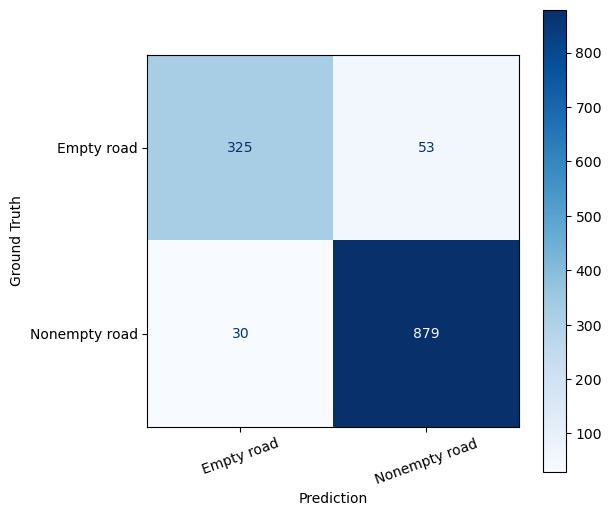

In [37]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score,accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
# from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt
## network loading
import torch
import torch.nn as nn
from torchsummary import summary as model_summary
import os


class NET(nn.Module):
    def __init__(self):
        super().__init__()

        self.in_channels = 3
        self.output_dim = 2
        self.avgpool = nn.AdaptiveAvgPool2d(7)
        self.classifier = nn.Sequential(
            nn.Linear(32 * 7 * 7, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, self.output_dim),
        )
        self.features = self.get_layers()  # must put here, not in forward method

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x

    def get_layers(self):
        net_config = [8, 8, 'M', 16, 16, 'M', 16, 16, 'M', 32, 32, 'M', 32, 32, 'M']
        batch_norm = True
        layers = []
        # in_channels= self.in_channels
        in_channels = 3
        for c in net_config:
            assert c == 'M' or isinstance(c, int)
            if c == 'M':
                layers += [nn.MaxPool2d(kernel_size=2)]
            else:
                conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = c
        return nn.Sequential(*layers)
    


# set with/no vehicle detection model
# root = 'C:/dataset/traffic'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

# load own model
# net_config = [8, 8, 'M', 16, 16, 'M', 16, 16, 'M', 32, 32, 'M', 32, 32, 'M']
# OUTPUT_DIM = 2
# layers = get_layers(net_config, batch_norm=True)
model = NET().to(device)

root = '/home/royliu/Documents/dataset/traffic'  
# model.load_state_dict(torch.load(os.path.join(root,'./pt_files/net_simple-model.pt'))) #net_simple-model0 is trained on 20221103
# model.load_state_dict(torch.load(os.path.join(root,'./pt_files/net_simple-model_20230101.pt')))
model.load_state_dict(torch.load(os.path.join(root,'./pt_files/net_simple-model_20221214.pt')))


def get_predictions(model, iterator):
    model.eval()
    images = []
    labels = []
    probs = []
    with torch.no_grad():
        for (x, y) in tqdm(iterator):
            x = x.to(device)
            y_pred = model(x)
            y_prob = F.softmax(y_pred, dim=-1)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)
    return images, labels, probs

def plot_confusion_matrix(labels, pred_labels, classes):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    plt.xticks(rotation=20)
    ax.set_xlabel('Prediction');ax.set_ylabel('Ground Truth')
    plt.show()
    plot_dir = '../result/' #ubuntu
#     plot_dir = 'C:/study/Dropbox/research/0_Object_classification_detection/paper/'  #home win10

    cm.figure_.savefig(plot_dir+'confusion_matrix_a.pdf',bbox_inches='tight')


classes = ['Empty road', 'Nonempty road']
images, labels, probs = get_predictions(model, dataset_test)

pred_labels = torch.argmax(probs, 1)  #for confusion matrix
print('sklearn Acc: %f, Recall: %f, Precision: %F, F1: %f '% (accuracy_score(labels, pred_labels),\
    recall_score(labels, pred_labels), precision_score(labels, pred_labels), f1_score(labels, pred_labels)))
plot_confusion_matrix(labels, pred_labels, classes)


